Initialized EDFAnalyzer with 4 EDF files in /Users/gusgoodman/Documents/V89/data_2
Loading 4 EDF files...
------------------------------------------------------------
✅ Loaded 00000995-100507[001].edf — 20 channels, 3600.0s, fs=mixed
✅ Loaded 00000995-100507[002].edf — 20 channels, 3600.0s, fs=mixed
✅ Loaded 00000995-100507[003].edf — 20 channels, 3600.0s, fs=mixed
✅ Loaded 00000995-100507[004].edf — 20 channels, 3600.0s, fs=mixed
------------------------------------------------------------
✅ Successfully loaded 4/4 files


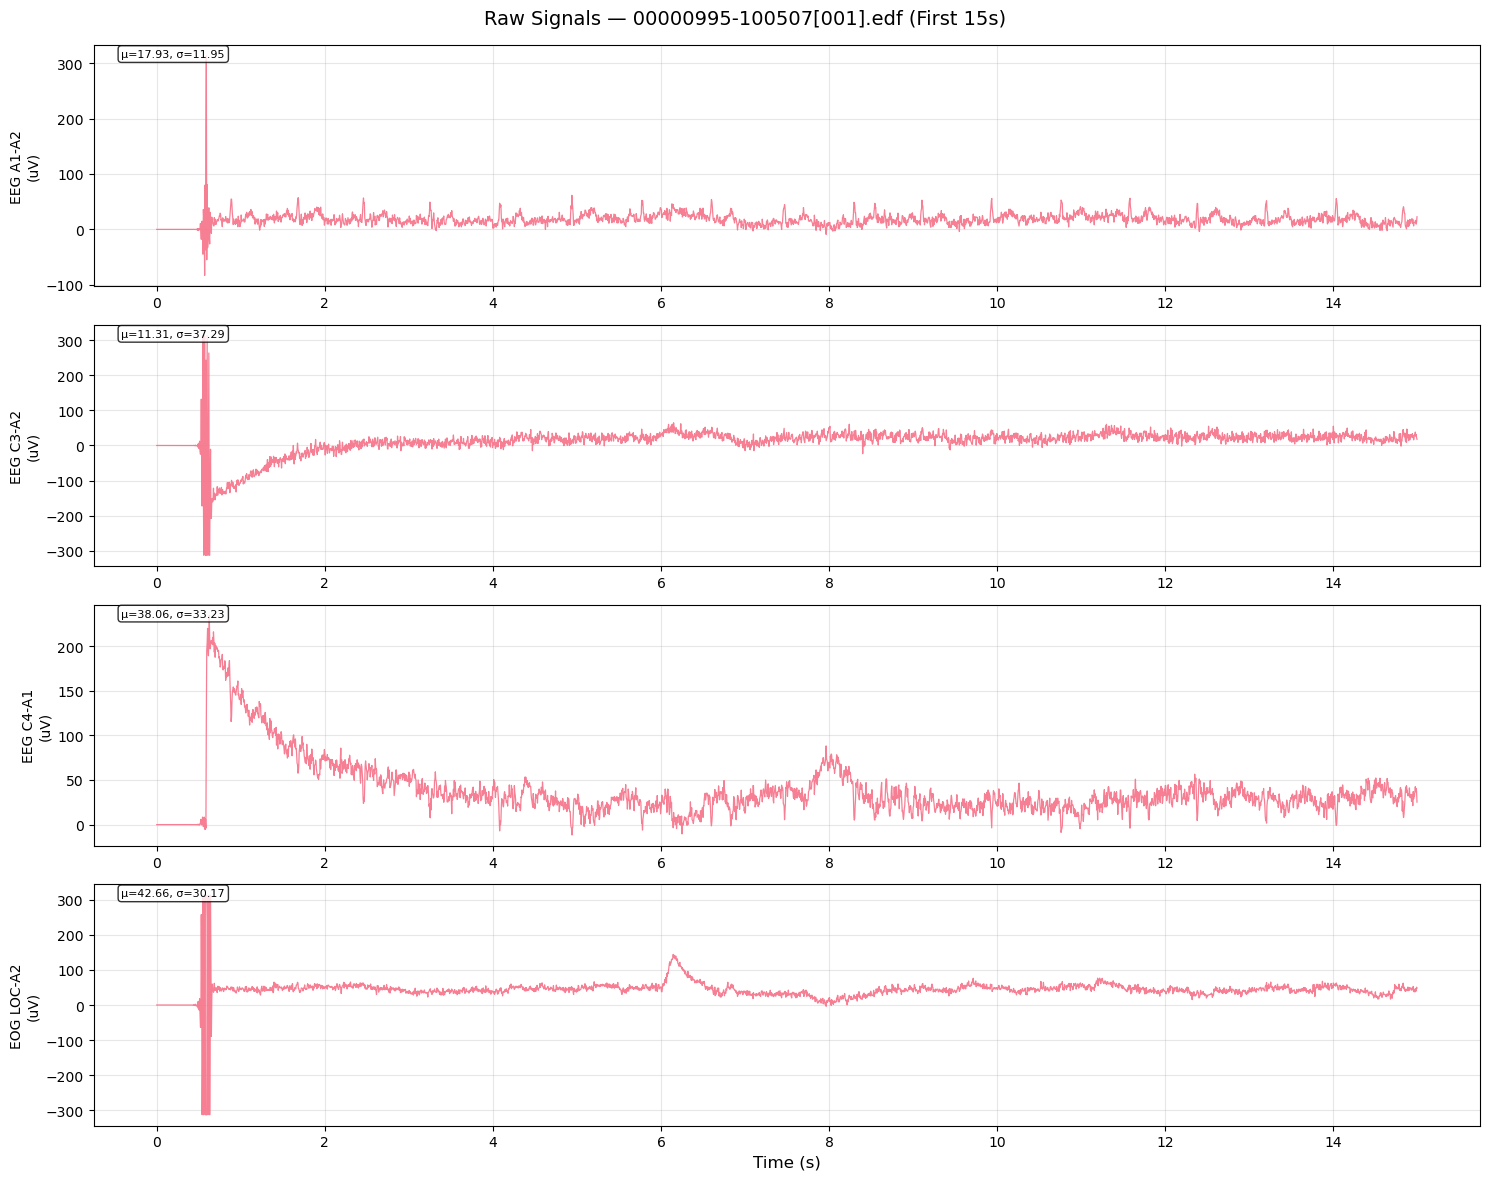

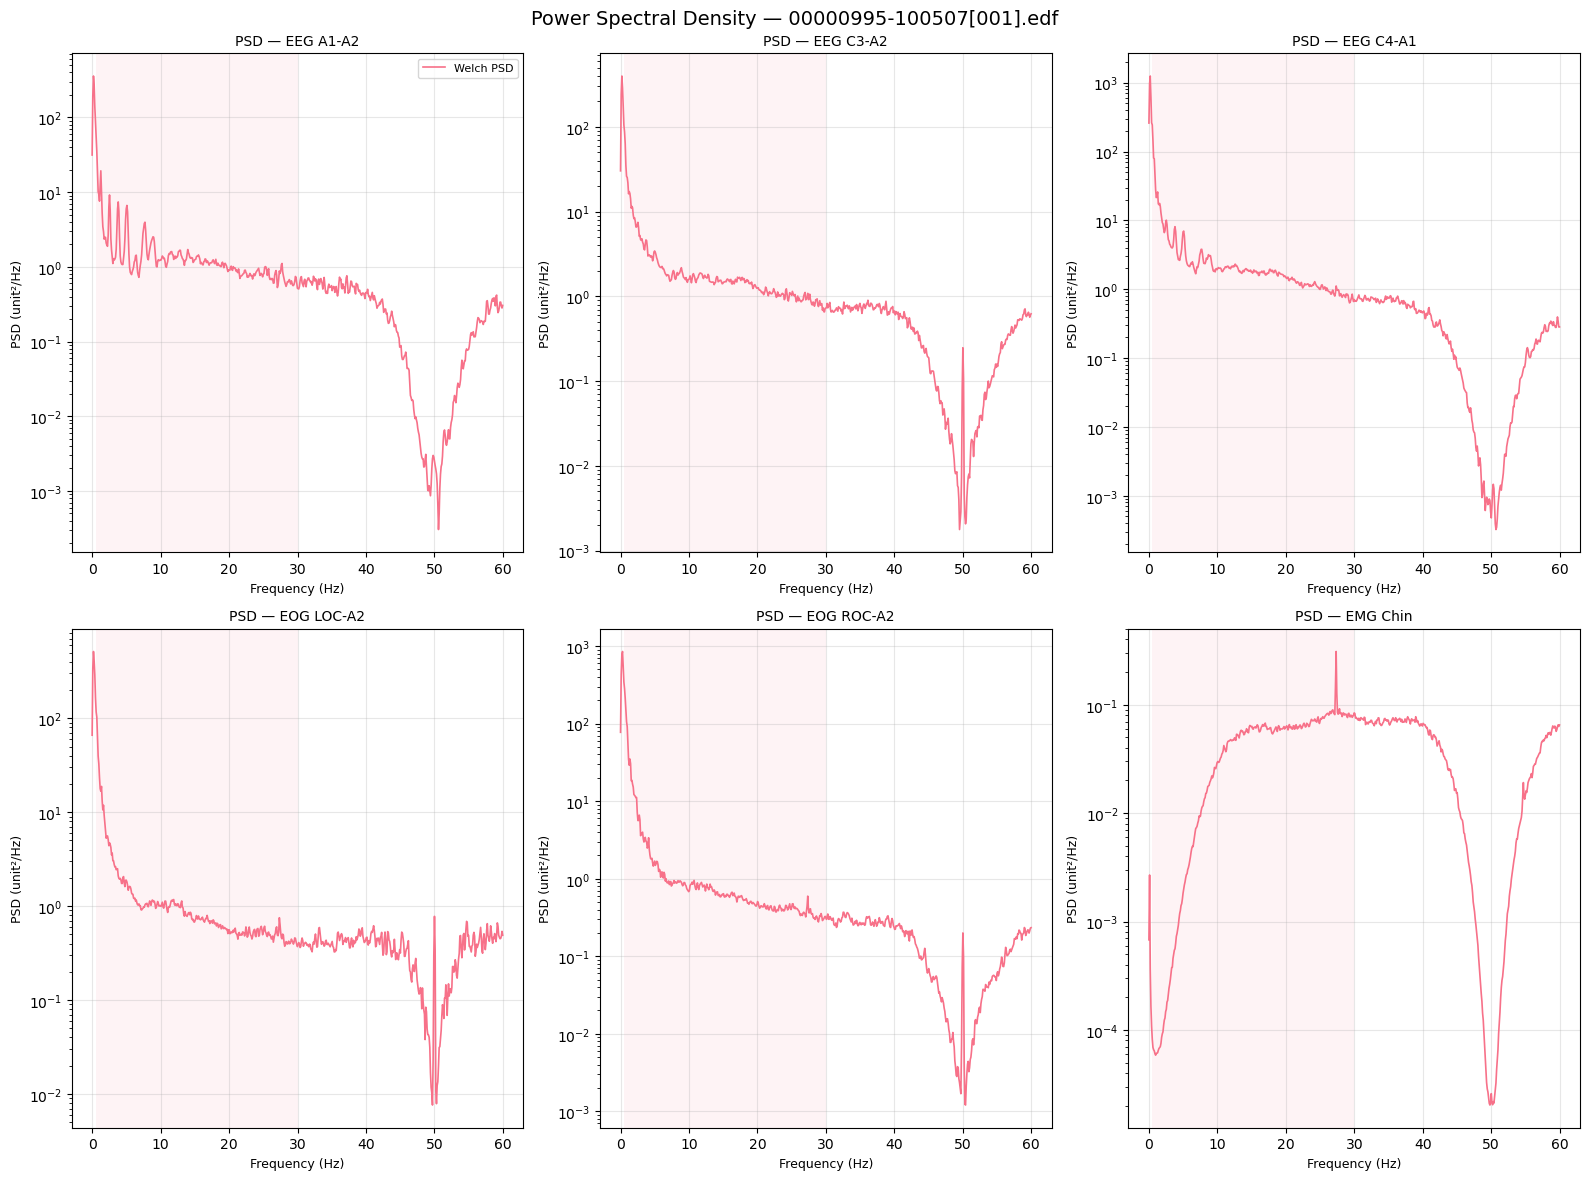

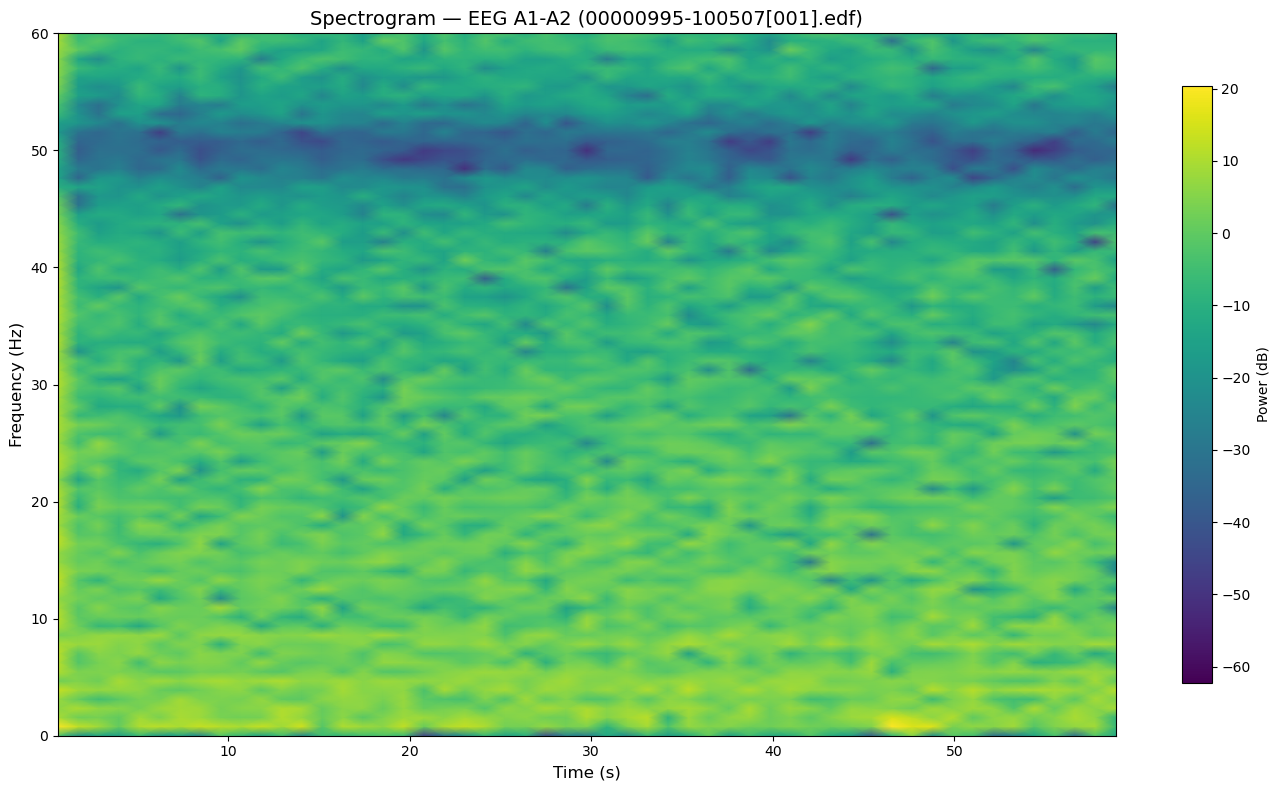

(array([  0.     ,   0.78125,   1.5625 ,   2.34375,   3.125  ,   3.90625,
          4.6875 ,   5.46875,   6.25   ,   7.03125,   7.8125 ,   8.59375,
          9.375  ,  10.15625,  10.9375 ,  11.71875,  12.5    ,  13.28125,
         14.0625 ,  14.84375,  15.625  ,  16.40625,  17.1875 ,  17.96875,
         18.75   ,  19.53125,  20.3125 ,  21.09375,  21.875  ,  22.65625,
         23.4375 ,  24.21875,  25.     ,  25.78125,  26.5625 ,  27.34375,
         28.125  ,  28.90625,  29.6875 ,  30.46875,  31.25   ,  32.03125,
         32.8125 ,  33.59375,  34.375  ,  35.15625,  35.9375 ,  36.71875,
         37.5    ,  38.28125,  39.0625 ,  39.84375,  40.625  ,  41.40625,
         42.1875 ,  42.96875,  43.75   ,  44.53125,  45.3125 ,  46.09375,
         46.875  ,  47.65625,  48.4375 ,  49.21875,  50.     ,  50.78125,
         51.5625 ,  52.34375,  53.125  ,  53.90625,  54.6875 ,  55.46875,
         56.25   ,  57.03125,  57.8125 ,  58.59375,  59.375  ,  60.15625,
         60.9375 ,  61.71875,  62.5   

In [7]:
from edf_analyzer import EDFAnalyzer

an = EDFAnalyzer("/Users/gusgoodman/Documents/V89/data_2", style='default')
an.load_all_files()

# ตารางสรุปไฟล์
an.get_metadata_summary()

# ดูสัญญาณ 4 ช่องแรกช่วง 15 วินาทีแรก
an.plot_raw_signals(max_duration=15, max_channels=4)

# PSD ถึง 60 Hz
an.power_spectral_analysis(max_channels=6, max_freq=60)

# Spectrogram ช่อง 0 ยาว 60 วินาที
an.create_spectrogram(channel_idx=0, max_duration=60, max_freq=60)


# RML check

In [12]:
import os
import xml.etree.ElementTree as ET

def inspect_rml_events(folder_path):
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(".rml"):
            file_path = os.path.join(folder_path, fname)
            try:
                tree = ET.parse(file_path)
                root = tree.getroot()

                events = root.findall('.//ScoredEvent')
                event_names = set()
                for e in events:
                    name_tag = e.find('EventConcept')
                    if name_tag is not None:
                        event_names.add(name_tag.text)

                print("="*60)
                print(f"File: {fname}")
                print(f"Total events: {len(events)}")
                print(f"Unique event classes: {len(event_names)}")
                print(f"Event types: {sorted(event_names)}")
                if events:
                    print("First 5 events:", [(e.find('EventConcept').text,
                                               e.find('Start').text,
                                               e.find('Duration').text) 
                                              for e in events[:5]])
            except Exception as e:
                print(f"Error parsing {fname}: {e}")

# Example usage
inspect_rml_events("/Users/gusgoodman/Documents/V89/data_2")


File: 00001006-100507 (1).rml
Total events: 0
Unique event classes: 0
Event types: []
File: 00000999-100507 (2).rml
Total events: 0
Unique event classes: 0
Event types: []
File: 00001000-100507 (1).rml
Total events: 0
Unique event classes: 0
Event types: []
File: 00000995-100507 (2).rml
Total events: 0
Unique event classes: 0
Event types: []
File: 00000999-100507.rml
Total events: 0
Unique event classes: 0
Event types: []
File: 00001006-100507.rml
Total events: 0
Unique event classes: 0
Event types: []
File: 00001000-100507.rml
Total events: 0
Unique event classes: 0
Event types: []
File: 00000995-100507 (1).rml
Total events: 0
Unique event classes: 0
Event types: []
File: 00001000-100507 (2).rml
Total events: 0
Unique event classes: 0
Event types: []
File: 00000995-100507.rml
Total events: 0
Unique event classes: 0
Event types: []
File: 00001006-100507 (2).rml
Total events: 0
Unique event classes: 0
Event types: []
File: 00000999-100507 (1).rml
Total events: 0
Unique event classes: 0


In [16]:
# rml_inspect.py
from pathlib import Path
import re
import xml.etree.ElementTree as ET
from collections import Counter

def _clean_xml(xml_text: str) -> str:
    """Remove namespaces and prefixed tags to make parsing namespace-agnostic."""
    xml_text = re.sub(r'xmlns(:\w+)?="[^"]+"', '', xml_text)
    xml_text = re.sub(r'<(/?)(\w+):', r'<\1', xml_text)
    return xml_text

def parse_rml(rml_path: str):
    """Parse a PSG-Audio RML file and return recording info + events."""
    text = Path(rml_path).read_text(encoding="utf-8", errors="ignore")
    root = ET.fromstring(_clean_xml(text))

    # Recording/session metadata
    rec_start = (root.find(".//RecordingStart").text
                 if root.find(".//RecordingStart") is not None else None)
    segments = []
    for seg in root.findall(".//Sessions/Session/Segments/Segment"):
        st = seg.find("StartTime").text if seg.find("StartTime") is not None else None
        dur = seg.find("Duration").text if seg.find("Duration") is not None else None
        segments.append({"StartTime": st, "Duration": float(dur) if dur else None})

    # Events in PSG-Audio are under <Events><Event .../>
    events = []
    for ev in root.findall(".//Event"):
        fam = ev.attrib.get("Family")
        typ = ev.attrib.get("Type")
        start = ev.attrib.get("Start")
        dur = ev.attrib.get("Duration")
        events.append({
            "Family": fam,
            "Type": typ,
            "Start": float(start) if start else None,
            "Duration": float(dur) if dur else None
        })

    # Fallback for ScoredEvent-style (other datasets)
    for ev in root.findall(".//ScoredEvent"):
        concept = ev.findtext("EventConcept")
        start = ev.findtext("Start")
        dur = ev.findtext("Duration")
        fam = ev.findtext("Family")
        events.append({
            "Family": fam,
            "Type": concept,
            "Start": float(start) if start else None,
            "Duration": float(dur) if dur else None
        })

    return {"RecordingStart": rec_start, "Segments": segments, "Events": events}

def summarize_events(events):
    """Return counters by family and by type."""
    fam = Counter(e["Family"] for e in events if e["Family"])
    typ = Counter(e["Type"] for e in events if e["Type"])
    return fam, typ

# === Example usage (patient 995) ===
rml_path = "/Users/gusgoodman/Documents/V89/data_2/00000995-100507.rml"
info = parse_rml(rml_path)
fam_cnt, typ_cnt = summarize_events(info["Events"])

print("RecordingStart:", info["RecordingStart"])
print("Segments:", info["Segments"])
print("Family counts:", fam_cnt)
print("Type counts (top 10):", typ_cnt.most_common(10))

# Snore events preview
snore = [e for e in info["Events"] if e["Type"] and "snore" in e["Type"].lower()]
print("Snore count:", len(snore))
print("First 5 snore events:", snore[:5])


RecordingStart: 2019-04-17T22:35:00
Segments: [{'StartTime': '2019-04-17T22:35:00', 'Duration': 3600.0}, {'StartTime': '2019-04-17T23:35:00', 'Duration': 3600.0}, {'StartTime': '2019-04-18T00:35:00', 'Duration': 3600.0}, {'StartTime': '2019-04-18T01:35:00', 'Duration': 3600.0}, {'StartTime': '2019-04-18T02:35:00', 'Duration': 3491.0}]
Family counts: Counter({'Cardiac': 313, 'Neuro': 277, 'Respiratory': 221, 'SpO2': 139, 'User': 114, 'Nasal': 47})
Type counts (top 10): [('Arousal', 277), ('PttDrop', 253), ('Hypopnea', 140), ('RelativeDesaturation', 139), ('Gain', 72), ('ObstructiveApnea', 68), ('Tachycardia', 60), ('Snore', 47), ('ChannelFail', 42), ('MixedApnea', 13)]
Snore count: 47
First 5 snore events: [{'Family': 'Nasal', 'Type': 'Snore', 'Start': 3934.5, 'Duration': 3.5}, {'Family': 'Nasal', 'Type': 'Snore', 'Start': 4053.5, 'Duration': 9.5}, {'Family': 'Nasal', 'Type': 'Snore', 'Start': 4107.0, 'Duration': 4.5}, {'Family': 'Nasal', 'Type': 'Snore', 'Start': 4113.5, 'Duration': 9.

# Snore Sound

In [20]:
# play_snore.py
from pathlib import Path
import re
import xml.etree.ElementTree as ET
import numpy as np
import pyedflib
import sounddevice as sd

def _clean_xml(xml_text: str) -> str:
    # Remove namespaces and tag prefixes so we can parse without ns maps
    xml_text = re.sub(r'xmlns(:\w+)?="[^"]+"', '', xml_text)
    xml_text = re.sub(r'<(/?)(\w+):', r'<\1', xml_text)
    return xml_text

def parse_rml_events(rml_path: Path):
    """Return list of events dicts: {Family, Type, Start, Duration}."""
    xml_text = rml_path.read_text(encoding="utf-8", errors="ignore")
    root = ET.fromstring(_clean_xml(xml_text))
    events = []
    for ev in root.findall(".//Event"):
        fam = ev.attrib.get("Family")
        typ = ev.attrib.get("Type")
        start = ev.attrib.get("Start")
        dur = ev.attrib.get("Duration")
        events.append({
            "Family": fam,
            "Type": typ,
            "Start": float(start) if start else None,
            "Duration": float(dur) if dur else None
        })
    return events

def index_segments(edf_paths):
    """Return list with cumulative time windows for each EDF segment."""
    segs, t = [], 0.0
    for p in edf_paths:
        f = pyedflib.EdfReader(str(p))
        dur = float(f.file_duration)
        labels = f.getSignalLabels()
        f.close()
        segs.append({"path": p, "t0": t, "t1": t+dur, "labels": labels, "duration": dur})
        t += dur
    return segs

def pick_channel(labels, prefer=("Tracheal", "Microphone", "Snore")):
    """Return (index, name) of the first available preferred channel."""
    for name in prefer:
        if name in labels:
            return labels.index(name), name
    # Fallback: return first channel
    return 0, labels[0]

def play_event(folder, rml_name, event_type="Snore", which=0, gain=0.95, pad=(0.0, 0.0)):
    """
    Play a specific event by type.
    folder : directory containing EDF segments + the RML
    rml_name : which RML file to use (e.g., '00000995-100507.rml')
    event_type : e.g., 'Snore'
    which : which occurrence (0-based)
    gain : output gain after normalization
    pad : (pre_pad_sec, post_pad_sec) to add around the event
    """
    folder = Path(folder)
    rml_path = folder / rml_name
    edf_paths = sorted(folder.glob("*[[]*]*.edf"))  # matches ...[001].edf etc.

    # Parse events and filter by type (case-insensitive contains)
    events = parse_rml_events(rml_path)
    cand = [e for e in events if e["Type"] and event_type.lower() in e["Type"].lower()]
    if not cand:
        print(f"No events of type '{event_type}' in {rml_name}")
        return
    if which >= len(cand):
        print(f"Requested index {which} but found only {len(cand)} events.")
        return
    ev = cand[which]
    start_g, dur = ev["Start"], ev["Duration"]

    # Build segment index
    segs = index_segments(edf_paths)

    # Find which segment this global start falls into
    seg = next((s for s in segs if s["t0"] <= start_g < s["t1"]), None)
    if seg is None:
        print("Event start does not fall into any EDF segment.")
        return

    # Convert global time to local segment time (with padding)
    pre, post = pad
    start_local = max(0.0, start_g - seg["t0"] - pre)
    dur_local = min(dur + pre + post, seg["duration"] - start_local)

    # Open EDF segment and read the chosen channel
    f = pyedflib.EdfReader(str(seg["path"]))
    ch_idx, ch_name = pick_channel(seg["labels"])
    fs = float(f.getSampleFrequency(ch_idx))
    s0 = int(start_local * fs)
    s1 = s0 + int(dur_local * fs)
    sig = f.readSignal(ch_idx)[s0:s1]
    f.close()

    # Normalize and play
    if sig.size == 0:
        print("Empty slice; check timing or padding.")
        return
    sig = sig.astype(np.float64)
    peak = np.max(np.abs(sig))
    if peak > 0:
        sig = gain * (sig / peak)

    print(f"Playing {event_type} #{which+1}: segment={seg['path'].name}, "
          f"channel={ch_name}, fs={int(fs)}, "
          f"t_local={start_local:.2f}s, dur={dur_local:.2f}s")
    sd.play(sig, samplerate=int(fs))
    sd.wait()
def play_multiple_events(folder, rml_name, event_type="Snore", start_idx=0, num_events=3, gain=0.95, pad=(0.0, 0.0), pause_between=1.0):
    """
    Play multiple events consecutively.
    folder : directory containing EDF segments + the RML
    rml_name : which RML file to use (e.g., '00000995-100507.rml')
    event_type : e.g., 'Snore'
    start_idx : starting event index (0-based)
    num_events : number of events to play
    gain : output gain after normalization
    pad : (pre_pad_sec, post_pad_sec) to add around each event
    pause_between : seconds to pause between events
    """
    import time
    
    folder = Path(folder)
    rml_path = folder / rml_name
    edf_paths = sorted(folder.glob("*[[]*]*.edf"))

    # Parse events and filter by type
    events = parse_rml_events(rml_path)
    cand = [e for e in events if e["Type"] and event_type.lower() in e["Type"].lower()]
    
    if not cand:
        print(f"No events of type '{event_type}' in {rml_name}")
        return
    
    # Validate range
    end_idx = min(start_idx + num_events, len(cand))
    actual_num = end_idx - start_idx
    
    if start_idx >= len(cand):
        print(f"Start index {start_idx} is beyond available events ({len(cand)} total)")
        return
    
    print(f"Found {len(cand)} {event_type} events. Playing {actual_num} events from index {start_idx}")
    
    # Build segment index once
    segs = index_segments(edf_paths)
    
    for i in range(start_idx, end_idx):
        print(f"\n--- Event {i+1}/{len(cand)} ---")
        
        ev = cand[i]
        start_g, dur = ev["Start"], ev["Duration"]
        
        # Find segment
        seg = next((s for s in segs if s["t0"] <= start_g < s["t1"]), None)
        if seg is None:
            print(f"Event {i+1} start does not fall into any EDF segment. Skipping.")
            continue
        
        # Convert to local time with padding
        pre, post = pad
        start_local = max(0.0, start_g - seg["t0"] - pre)
        dur_local = min(dur + pre + post, seg["duration"] - start_local)
        
        # Read signal
        f = pyedflib.EdfReader(str(seg["path"]))
        ch_idx, ch_name = pick_channel(seg["labels"])
        fs = float(f.getSampleFrequency(ch_idx))
        s0 = int(start_local * fs)
        s1 = s0 + int(dur_local * fs)
        sig = f.readSignal(ch_idx)[s0:s1]
        f.close()
        
        # Normalize and play
        if sig.size == 0:
            print(f"Empty slice for event {i+1}; skipping.")
            continue
            
        sig = sig.astype(np.float64)
        peak = np.max(np.abs(sig))
        if peak > 0:
            sig = gain * (sig / peak)
        
        print(f"Playing {event_type} #{i+1}: segment={seg['path'].name}, "
              f"channel={ch_name}, fs={int(fs)}, "
              f"t_global={start_g:.1f}s, t_local={start_local:.2f}s, dur={dur_local:.2f}s")
        
        sd.play(sig, samplerate=int(fs))
        sd.wait()
        
        # Pause between events (except after the last one)
        if i < end_idx - 1 and pause_between > 0:
            print(f"Pausing {pause_between}s...")
            time.sleep(pause_between)

def play_random_events(folder, rml_name, event_type="Snore", num_events=3, gain=0.95, pad=(0.0, 0.0)):
    """Play random sample of events."""
    import random
    
    folder = Path(folder)
    rml_path = folder / rml_name
    
    # Get all events of type
    events = parse_rml_events(rml_path)
    cand = [e for e in events if e["Type"] and event_type.lower() in e["Type"].lower()]
    
    if not cand:
        print(f"No events of type '{event_type}' found")
        return
    
    # Sample random events
    sample_size = min(num_events, len(cand))
    selected_indices = sorted(random.sample(range(len(cand)), sample_size))
    
    print(f"Randomly selected {sample_size} events from {len(cand)} total: {selected_indices}")
    
    for idx in selected_indices:
        play_event(folder, rml_name, event_type, which=idx, gain=gain, pad=pad)
        print()  # Add spacing between events
# Example usage:
# folder = "/Users/gusgoodman/Documents/V89/data_2"
# play_event(folder, "00000995-100507.rml", event_type="Snore", which=0, pad=(0.5, 0.5))


In [19]:
folder = "/Users/gusgoodman/Documents/V89/data_2"
play_event(folder, "00000995-100507.rml", event_type="Snore", which=0, pad=(0.5, 0.5))


Playing Snore #1: segment=00000995-100507[002].edf, channel=Tracheal, fs=48000, t_local=334.00s, dur=4.50s


In [3]:
# # เล่น 5 events ติดต่อกัน (events 0-4)
# play_multiple_events("/Users/gusgoodman/Documents/V89/data_2", "00000995-100507.rml", 
#                     event_type="Snore", start_idx=0, num_events=5, pad=(0.5, 0.5), pause_between=2.0)

# # เล่น 3 events แบบสุ่ม
# play_random_events("/Users/gusgoodman/Documents/V89/data_2", "00000995-100507.rml", 
#                   event_type="Snore", num_events=3, pad=(0.5, 0.5))

# try CSV with EDF
## Plot Graph that check it work to turn .rml to csv

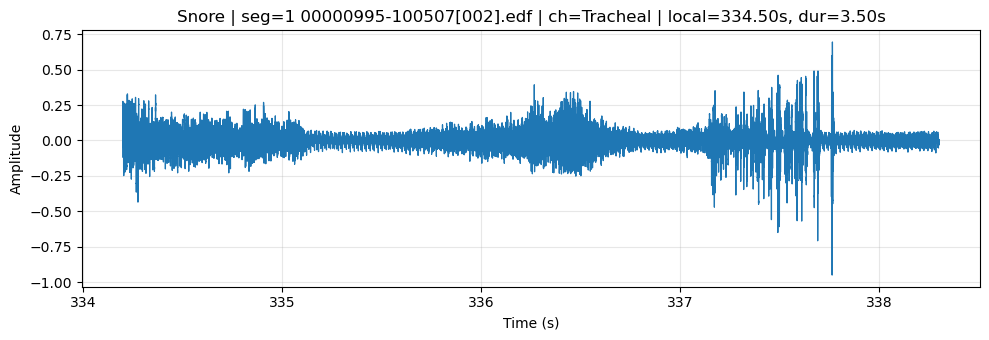

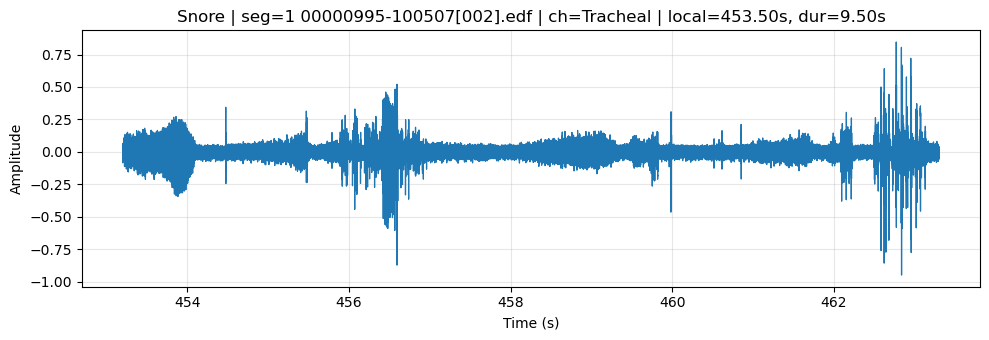

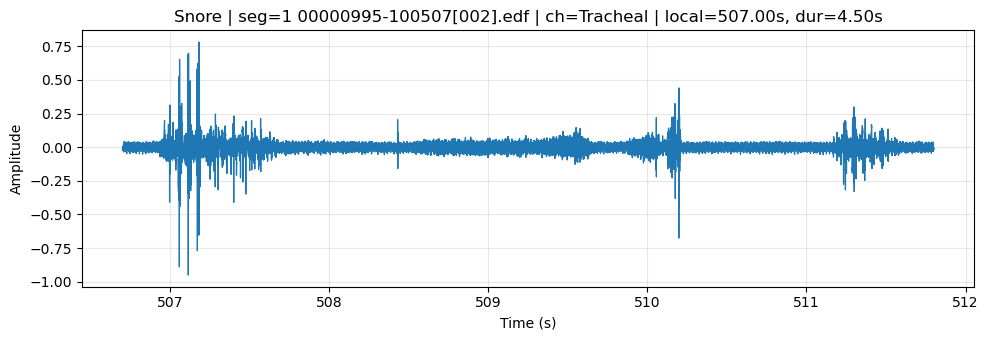

In [5]:
# use_csv_with_multi_edf.py
from pathlib import Path
import pandas as pd
import numpy as np
import pyedflib
import matplotlib.pyplot as plt

# -------- config --------
patient_id = "00000995"
csv_path = Path("/Users/gusgoodman/Documents/V89/rml_csv") / f"{patient_id}.csv"
data_dir = Path("/Users/gusgoodman/Documents/V89/data_2")  # folder with EDFs and RMLs
prefer_channels = ("Tracheal", "Microphone", "Snore")      # channel priority
event_filter = "Snore"                                     # choose event type to demo
n_examples = 3                                             # how many events to extract/plot
pre_pad, post_pad = 0.3, 0.3                               # seconds around event
# ------------------------

def list_edf_segments(folder: Path, pid: str):
    """Return EDF paths sorted by segment number [001],[002],…"""
    edfs = sorted(folder.glob(f"{pid}-*[*]*.edf"))  # matches 00000995-100507[001].edf etc.
    if not edfs:
        # fallback if your naming scheme differs
        edfs = sorted(folder.glob(f"{pid}*.edf"))
    return edfs

def pick_channel(labels, prefer=("Tracheal","Microphone","Snore")):
    """Pick first available preferred channel; fallback to first."""
    for name in prefer:
        if name in labels:
            return labels.index(name), name
    return 0, labels[0]

def edf_durations(paths):
    """Return list of durations and cumulative windows for each EDF segment."""
    durs, cum = [], []
    t = 0.0
    for p in paths:
        f = pyedflib.EdfReader(str(p))
        dur = float(f.file_duration)
        f.close()
        durs.append(dur)
        cum.append((t, t + dur))
        t += dur
    return durs, cum

def locate_segment_from_global_start(t_global, cum_windows):
    """Return segment index where t_global falls; -1 if not found."""
    for i, (t0, t1) in enumerate(cum_windows):
        if t0 <= t_global < t1:
            return i
    return -1

# 1) Load CSV and EDF list
df = pd.read_csv(csv_path)
edf_paths = list_edf_segments(data_dir, patient_id)
if not edf_paths:
    raise FileNotFoundError("No EDF segments found for this patient.")

# 2) Prepare cumulative windows in case CSV lacks segment_index
durations, cum_windows = edf_durations(edf_paths)

# 3) Filter events you want (e.g., Snore) and take first N
events = df[df["type"].str.contains(event_filter, case=False, na=False)].copy()
if events.empty:
    raise RuntimeError(f"No events of type '{event_filter}' in CSV.")
events = events.sort_values("start_sec").head(n_examples)

# 4) Extract and plot each event from the correct EDF file
for idx, row in events.iterrows():
    # Prefer using segment_index/segment_local_start_sec from CSV if present
    if "segment_index" in row and pd.notna(row["segment_index"]) and int(row["segment_index"]) >= 0:
        seg_idx = int(row["segment_index"])
        local_start = float(row["segment_local_start_sec"])
    else:
        # Fallback: compute from global start
        seg_idx = locate_segment_from_global_start(float(row["start_sec"]), cum_windows)
        if seg_idx < 0:
            print(f"Skip event at {row['start_sec']:.2f}s (out of window).")
            continue
        local_start = float(row["start_sec"]) - cum_windows[seg_idx][0]

    edf_path = edf_paths[seg_idx]
    duration = float(row["duration_sec"])

    f = pyedflib.EdfReader(str(edf_path))
    labels = f.getSignalLabels()
    ch_idx, ch_name = pick_channel(labels, prefer_channels)
    fs = int(f.getSampleFrequency(ch_idx))

    # Apply padding and clamp to segment duration
    start_s = max(0.0, local_start - pre_pad)
    end_s = min(local_start + duration + post_pad, float(f.file_duration))
    s0 = int(start_s * fs)
    s1 = int(end_s * fs)

    sig = f.readSignal(ch_idx)[s0:s1]
    f.close()

    if sig.size == 0:
        print(f"Empty slice for event {row['event_id']} in segment {edf_path.name}")
        continue

    # Normalize for inspection
    peak = np.max(np.abs(sig))
    if peak > 0:
        sig = 0.95 * sig / peak

    # Plot waveform
    t = np.arange(sig.size) / fs + start_s
    plt.figure(figsize=(10, 3.5))
    plt.plot(t, sig, linewidth=0.9)
    plt.title(f"{row['type']} | seg={seg_idx} {edf_path.name} | ch={ch_name} | "
              f"local={local_start:.2f}s, dur={duration:.2f}s")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Optional: compute a simple log-spectrogram
    # import scipy.signal as sg
    # fxx, txx, Sxx = sg.spectrogram(sig, fs=fs, nperseg=1024)
    # plt.figure(figsize=(8, 4))
    # plt.pcolormesh(txx + start_s, fxx, 10*np.log10(Sxx + 1e-12), shading="gouraud")
    # plt.ylim(0, min(4000, fs/2))  # tighten if using 48 kHz channels
    # plt.xlabel("Time (s)"); plt.ylabel("Hz"); plt.title("Log-Spectrogram")
    # plt.colorbar(label="dB")
    # plt.tight_layout(); plt.show()


# Output Snore sound
### use .csv and .edf to output snore sound

In [ ]:
# play_from_csv.py
from pathlib import Path
import pandas as pd
import numpy as np
import pyedflib

# Optional: notebook audio player (no extra install)
from IPython.display import Audio, display

# Optional: realtime playback (needs: pip install sounddevice)
try:
    import sounddevice as sd
    HAS_SD = True
except Exception:
    HAS_SD = False

# --- config ---
patient_id = "00000995"
csv_path = Path("/Users/gusgoodman/Documents/V89/rml_csv") / f"{patient_id}.csv"
data_dir = Path("/Users/gusgoodman/Documents/V89/data_2")
prefer_channels = ("Tracheal", "Microphone", "Snore")  # priority for audio
event_filter = "Snore"                                  # which event type to play
idx_to_play = 0                                         # which occurrence to play
pre_pad, post_pad = 0.4, 0.4                            # seconds around the event
use_sounddevice = False                                 # True = sd.play, False = display(Audio)
# ---------------

def list_edf_segments(folder: Path, pid: str):
    paths = sorted(folder.glob(f"{pid}-*[*]*.edf"))  # e.g., ...[001].edf
    if not paths:
        paths = sorted(folder.glob(f"{pid}*.edf"))
    return paths

def pick_channel(labels, prefer):
    for name in prefer:
        if name in labels:
            return labels.index(name), name
    return 0, labels[0]

def edf_cum_windows(paths):
    wins, t = [], 0.0
    for p in paths:
        f = pyedflib.EdfReader(str(p))
        dur = float(f.file_duration)
        f.close()
        wins.append((p, t, t + dur, dur))
        t += dur
    return wins

def locate_segment(t_global, wins):
    for i, (p, t0, t1, dur) in enumerate(wins):
        if t0 <= t_global < t1:
            return i
    return -1

# 1) load CSV and EDF list
df = pd.read_csv(csv_path)
edf_paths = list_edf_segments(data_dir, patient_id)
wins = edf_cum_windows(edf_paths)

# 2) pick an event row
evs = df[df["type"].str.contains(event_filter, case=False, na=False)].sort_values("start_sec")
if evs.empty:
    raise RuntimeError(f"No '{event_filter}' events in CSV.")
row = evs.iloc[idx_to_play]

# 3) decide segment and local start
if "segment_index" in row and pd.notna(row["segment_index"]) and int(row["segment_index"]) >= 0:
    seg_idx = int(row["segment_index"])
    local_start = float(row["segment_local_start_sec"])
else:
    seg_idx = locate_segment(float(row["start_sec"]), wins)
    if seg_idx < 0:
        raise RuntimeError("Event is outside available EDF segments.")
    local_start = float(row["start_sec"]) - wins[seg_idx][1]

edf_path = edf_paths[seg_idx]
duration = float(row["duration_sec"])

# 4) read the slice
f = pyedflib.EdfReader(str(edf_path))
labels = f.getSignalLabels()
ch_idx, ch_name = pick_channel(labels, prefer_channels)
fs = int(f.getSampleFrequency(ch_idx))

start_s = max(0.0, local_start - pre_pad)
end_s = min(local_start + duration + post_pad, float(f.file_duration))
s0 = int(start_s * fs)
s1 = int(end_s * fs)
sig = f.readSignal(ch_idx)[s0:s1]
f.close()

# normalize for comfortable listening
sig = sig.astype(np.float64)
peak = np.max(np.abs(sig))
if peak > 0:
    sig = 0.95 * sig / peak

print(f"Playing {row['type']} | seg={seg_idx} {edf_path.name} | ch={ch_name} | "
      f"local={local_start:.2f}s dur={duration:.2f}s fs={fs}")

# 5A) inline player (works in Jupyter)
if not use_sounddevice:
    display(Audio(sig, rate=fs))
# 5B) realtime playback (works in terminals/notebooks with audio device)
else:
    if not HAS_SD:
        raise RuntimeError("sounddevice not installed. Set use_sounddevice=False or pip install sounddevice")
    import time
    sd.play(sig, samplerate=fs)
    sd.wait()
